# Importing data and libraries. and simple print Statements and plots. 

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import tqdm
import ast
literal_eval = ast.literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re
from scipy.stats import chi2_contingency


In [6]:
# Load ALL businesses
BUSINESSES = pd.read_json("../data/yelp_academic_dataset_business.json", lines=True, engine="pyarrow")
# Dealing with Category
cat_freq =dict()
def get_categories(categories):
    categories = [cat.strip() for cat in categories.strip().split(',')]
    quoted_cats = [f'"{cat}"' for cat in categories]
    quoted_cats = '[' + ', '.join(quoted_cats) + ']'
    return quoted_cats
BUSINESSES = BUSINESSES.dropna(subset=['categories']).copy()
BUSINESSES['categories'] = BUSINESSES['categories'].apply(get_categories).apply(literal_eval)

cat_freq = {}
for ls in BUSINESSES['categories']:
    for cat in ls:
        cat_freq[cat] = cat_freq.get(cat, 0) + 1

# creating an attributes dataframe 
attribute_ls = list(BUSINESSES.iloc[0]['attributes'].keys())
attribute_freq = dict.fromkeys(attribute_ls, 0)
attribute_df = pd.DataFrame(columns=["business_id"]+attribute_ls)

rows = []

for _, row in tqdm.tqdm(BUSINESSES.iterrows(), total=BUSINESSES.shape[0]):
    id = row['business_id']
    attributes = row['attributes']
    
    new_row = [id] + [None] * len(attribute_ls)
    if isinstance(attributes, dict):
        for i, attr in enumerate(attribute_ls):
            value = attributes.get(attr)
            if value is not None:
                attribute_freq[attr] += 1
                try:
                    new_row[i + 1] = literal_eval(value)
                except:
                    new_row[i + 1] = value
                    print(f"Failed to parse {attr}: {value}, type: {type(value)}")

    rows.append(new_row)

attribute_df = pd.DataFrame(rows, columns=["business_id"] + attribute_ls)

# Loading All reviews
reviews = pd.read_json("../data/yelp_academic_dataset_review.json", lines=True,engine = "pyarrow")
reviews['date'] = pd.to_datetime(reviews['date'])
checkins = pd.read_json("../data/yelp_academic_dataset_checkin.json", lines=True, engine="pyarrow")



100%|██████████| 150243/150243 [00:15<00:00, 9421.00it/s] 


Filtering

In [7]:
# FILTERING STUFF
# Filter out businesses not in tampa and philadelphia
red_city = "Tampa"
blue_city = "Philadelphia"
businesses = BUSINESSES.copy()
businesses = businesses[businesses['city'].isin([red_city, blue_city])]

# Get the business ids for the two cities
red_business_ids = set(businesses[businesses['city'] == red_city]['business_id'])
blue_business_ids = set(businesses[businesses['city'] == blue_city]['business_id'])

# Filter reviews to only include those for businesses in the two cities
reviews = reviews[reviews['business_id'].isin(red_business_ids | blue_business_ids)]
checkins = checkins[checkins['business_id'].isin(red_business_ids | blue_business_ids)]
# Label the reviews with the city of the business
reviews.loc[reviews['business_id'].isin(red_business_ids), 'city'] = red_city
reviews.loc[reviews['business_id'].isin(blue_business_ids), 'city'] = blue_city

checkins.loc[checkins['business_id'].isin(red_business_ids), 'city'] = red_city
checkins.loc[checkins['business_id'].isin(blue_business_ids), 'city'] = blue_city   

# Fix date time format for both
checkins['date_list'] = None
checkins['date_list'] = checkins['date'].apply(lambda x: [datetime.datetime.strptime(date.strip(), "%Y-%m-%d %H:%M:%S") 
                                                         for date in x.split(',')])
reviews['date'] = pd.to_datetime(reviews['date'])

# Create a restaurant dataframe
restaurants = businesses[businesses['categories'].apply(lambda x: 'Restaurants' in x)]
restaurant_ids = restaurants['business_id'].tolist()

# filter reviews and checkins to only include those for restaurants operational during the pandemic
before_date = datetime.datetime(2020, 12, 30)
after_date = datetime.datetime(2020, 3, 1)


restaurants_reviews = reviews[reviews['business_id'].isin(restaurant_ids)]
covid_restaurants_reviews =restaurants_reviews[(reviews['date'] < before_date) &
                                                (reviews['date'] > after_date)  ]
covid_restaurants_checkins = checkins[checkins['business_id'].isin(restaurant_ids)]

checkin_ids = set()
for _, row in covid_restaurants_checkins.iterrows():
    # Check if any date in the list is after Jan 1, 2019
    if any((date < before_date) and (date > after_date) for date in row['date_list']):
        checkin_ids.add(row['business_id'])
covid_restaurants_checkins = covid_restaurants_checkins[covid_restaurants_checkins['business_id'].isin(checkin_ids)]

# Filter restaurants to only include those operational during the pandemic
restaurants_in_covid = restaurants[restaurants['business_id'].isin(restaurants_reviews['business_id'].tolist()+list(checkin_ids))]
open_restaurants = restaurants_in_covid[restaurants_in_covid['is_open'] == 1]
closed_restaurants = restaurants_in_covid[restaurants_in_covid['is_open'] == 0]

closed_reviews = covid_restaurants_reviews[covid_restaurants_reviews['business_id'].isin(closed_restaurants['business_id'].tolist())]
closed_checkins = checkins[checkins['business_id'].isin(closed_restaurants['business_id'].tolist())]

open_reviews = covid_restaurants_reviews[covid_restaurants_reviews['business_id'].isin(open_restaurants['business_id'].tolist())]
open_checkins = checkins[checkins['business_id'].isin(open_restaurants['business_id'].tolist())]


# create a shopping dataframe
shopping = businesses[businesses['categories'].apply(lambda x: 'Shopping' in x)]
shopping_ids = shopping['business_id'].tolist()

# Open and closed restaurants attributes
open_attributes = attribute_df[attribute_df['business_id'].isin(open_restaurants['business_id'].tolist())].copy()
closed_attributes = attribute_df[attribute_df['business_id'].isin(closed_restaurants['business_id'].tolist())].copy()


C:\Users\musti\AppData\Local\Temp\ipykernel_22040\2716570951.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  covid_restaurants_reviews =restaurants_reviews[(reviews['date'] < before_date) &


## Basic info and bar plots

Basic info of businesses data 

In [8]:
print(BUSINESSES.columns)
print("number of citys: ", BUSINESSES['city'].nunique())
print("number of states: ", BUSINESSES['state'].nunique())
print("number of categories: ", len(cat_freq))

freq_city = BUSINESSES['city'].value_counts()
print("mean number of business in a city: ", freq_city.mean())
print("median number of business in a city: ", freq_city.median())
print("max number of business in a city: ", freq_city.max(), "city: ", freq_city.idxmax())
print("number of cities with more  than 1000 business: ", freq_city[freq_city > 1000].count())
print("the cities with more than 1000: ", freq_city[freq_city > 1000].index.tolist())

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours'],
      dtype='object')
number of citys:  1415
number of states:  27
number of categories:  1311
mean number of business in a city:  106.17879858657244
median number of business in a city:  2.0
max number of business in a city:  14560 city:  Philadelphia
number of cities with more  than 1000 business:  21
the cities with more than 1000:  ['Philadelphia', 'Tucson', 'Tampa', 'Indianapolis', 'Nashville', 'New Orleans', 'Reno', 'Edmonton', 'Saint Louis', 'Santa Barbara', 'Boise', 'Clearwater', 'Saint Petersburg', 'Metairie', 'Sparks', 'Wilmington', 'Franklin', 'St. Louis', 'St. Petersburg', 'Meridian', 'Brandon']


Plotting frequency vs state and city

The following plot will show the number of business per state, moreover, the second plot will show which cities has the highest business count. Keep in mind that the data is subset of the whole yelp dataset, it contains 11 metropolitan areas. Since most data are in Tampa and Philadelphia, we will focus the rest of the exploration there.   

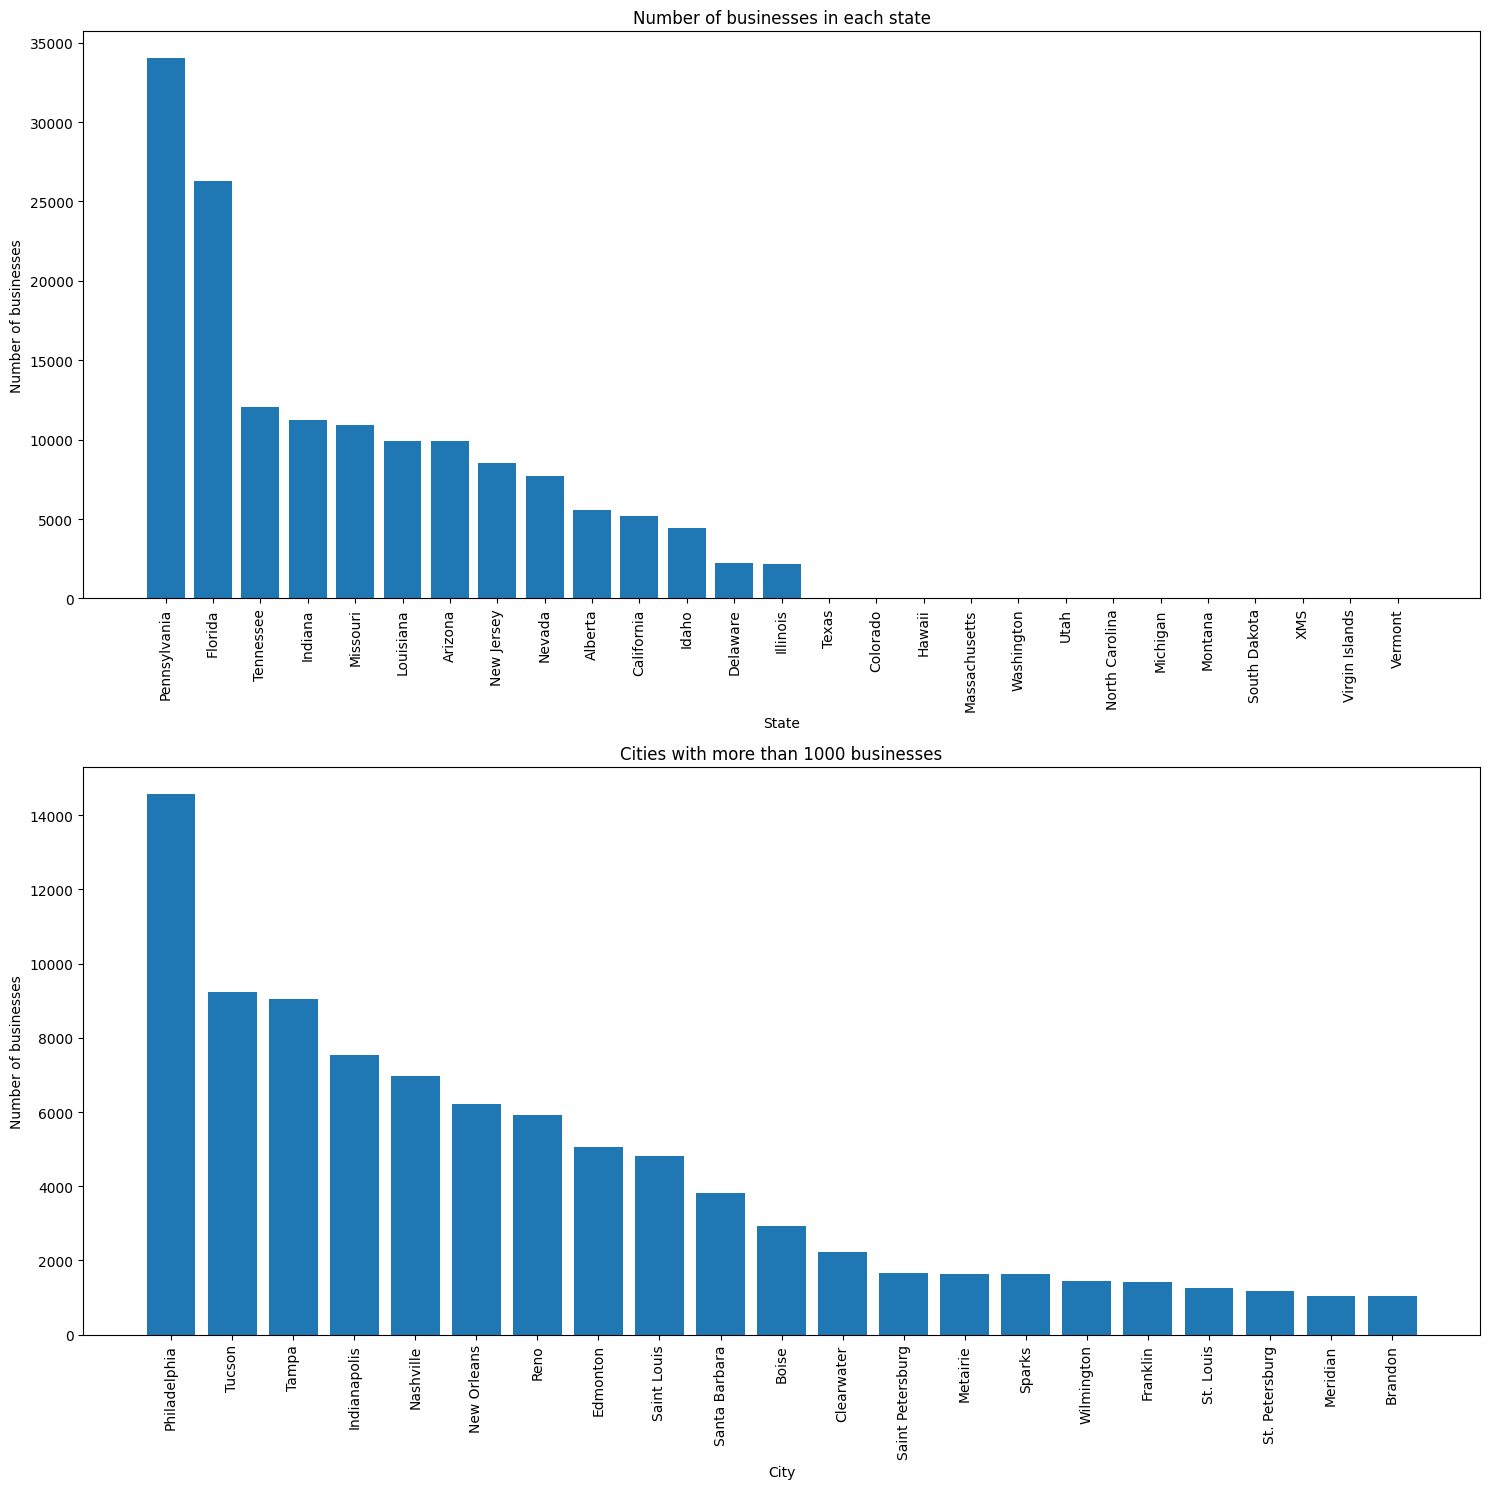

In [9]:
state_name_map = {
    'AK': 'Alaska',        'AL': 'Alabama',       'AR': 'Arkansas',      'AS': 'American Samoa', 'AZ': 'Arizona',       'CA': 'California',
    'CO': 'Colorado',      'CT': 'Connecticut',   'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida',      'FM': 'Federated States of Micronesia',
    'GA': 'Georgia',       'GU': 'Guam',          'HI': 'Hawaii',        'IA': 'Iowa',           'ID': 'Idaho',         'IL': 'Illinois',
    'IN': 'Indiana',       'KS': 'Kansas',        'KY': 'Kentucky',      'LA': 'Louisiana',      'MA': 'Massachusetts', 'MD': 'Maryland',
    'ME': 'Maine',         'MH': 'Marshall Islands', 'MI': 'Michigan',   'MN': 'Minnesota',      'MO': 'Missouri',      'MP': 'Northern Mariana Islands',
    'MS': 'Mississippi',   'MT': 'Montana',       'NC': 'North Carolina', 'ND': 'North Dakota',  'NE': 'Nebraska',      'NH': 'New Hampshire',
    'NJ': 'New Jersey',    'NM': 'New Mexico',    'NV': 'Nevada',        'NY': 'New York',       'OH': 'Ohio',          'OK': 'Oklahoma',
    'OR': 'Oregon',        'PA': 'Pennsylvania',  'PR': 'Puerto Rico',   'PW': 'Palau',          'RI': 'Rhode Island',  'SC': 'South Carolina',
    'SD': 'South Dakota',  'TN': 'Tennessee',     'TX': 'Texas',         'UT': 'Utah',           'VA': 'Virginia',      'VI': 'Virgin Islands',
    'VT': 'Vermont',       'WA': 'Washington',    'WI': 'Wisconsin',     'WV': 'West Virginia',  'WY': 'Wyoming', 
    "AB": 'Alberta'
}
freq_state = BUSINESSES['state'].value_counts()
mapped_states = [state_name_map.get(state, state) for state in freq_state.index]

fig,ax = plt.subplots(2, 1, figsize=(15, 15))
# First subplot - States
ax[0].bar(mapped_states, freq_state.values)
ax[0].set_title("Number of businesses in each state")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Number of businesses")
plt.setp(ax[0].get_xticklabels(), rotation=90)  # Rotate xticks

# Second subplot - Cities
ax[1].bar(freq_city.index[freq_city > 1000], freq_city.values[freq_city > 1000])
ax[1].set_title("Cities with more than 1000 businesses")
ax[1].set_xlabel("City")
ax[1].set_ylabel("Number of businesses")
plt.setp(ax[1].get_xticklabels(), rotation=90)  # Rotate xticks

# Adjust layout to prevent overlap
plt.tight_layout()

Category information and plot

Here we plot the count of business categories, where each business can have multiple categories. Moreover, looking at some of the top categories, it can be said that there is high overlap between some of these categories. Furthermore, when we state a business is a "restaurant" it means that it has the "Restaurants" category.   

number of categories:  1311
mean number of business in a category:  509.9862700228833
median number of business in a category:  66.0
max number of business in a category:  52268
max category:  Restaurants
number of categories with more than 1000 business:  125
the top 50 categories:  ['Restaurants', 'Food', 'Shopping', 'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical', 'Local Services', 'Bars', 'Automotive', 'Event Planning & Services', 'Sandwiches', 'American (Traditional)', 'Active Life', 'Pizza', 'Coffee & Tea', 'Fast Food', 'Breakfast & Brunch', 'American (New)', 'Hotels & Travel', 'Home & Garden', 'Fashion', 'Burgers', 'Arts & Entertainment', 'Auto Repair', 'Hair Salons', 'Nail Salons', 'Mexican', 'Italian', 'Specialty Food', 'Doctors', 'Pets', 'Real Estate', 'Seafood', 'Fitness & Instruction', 'Professional Services', 'Hair Removal', 'Desserts', 'Chinese', 'Bakeries', 'Grocery', 'Salad', 'Hotels', 'Chicken Wings', 'Cafes', 'Ice Cream & Frozen Yogurt', 'Caterers', 

Text(0, 0.5, 'Number of businesses')

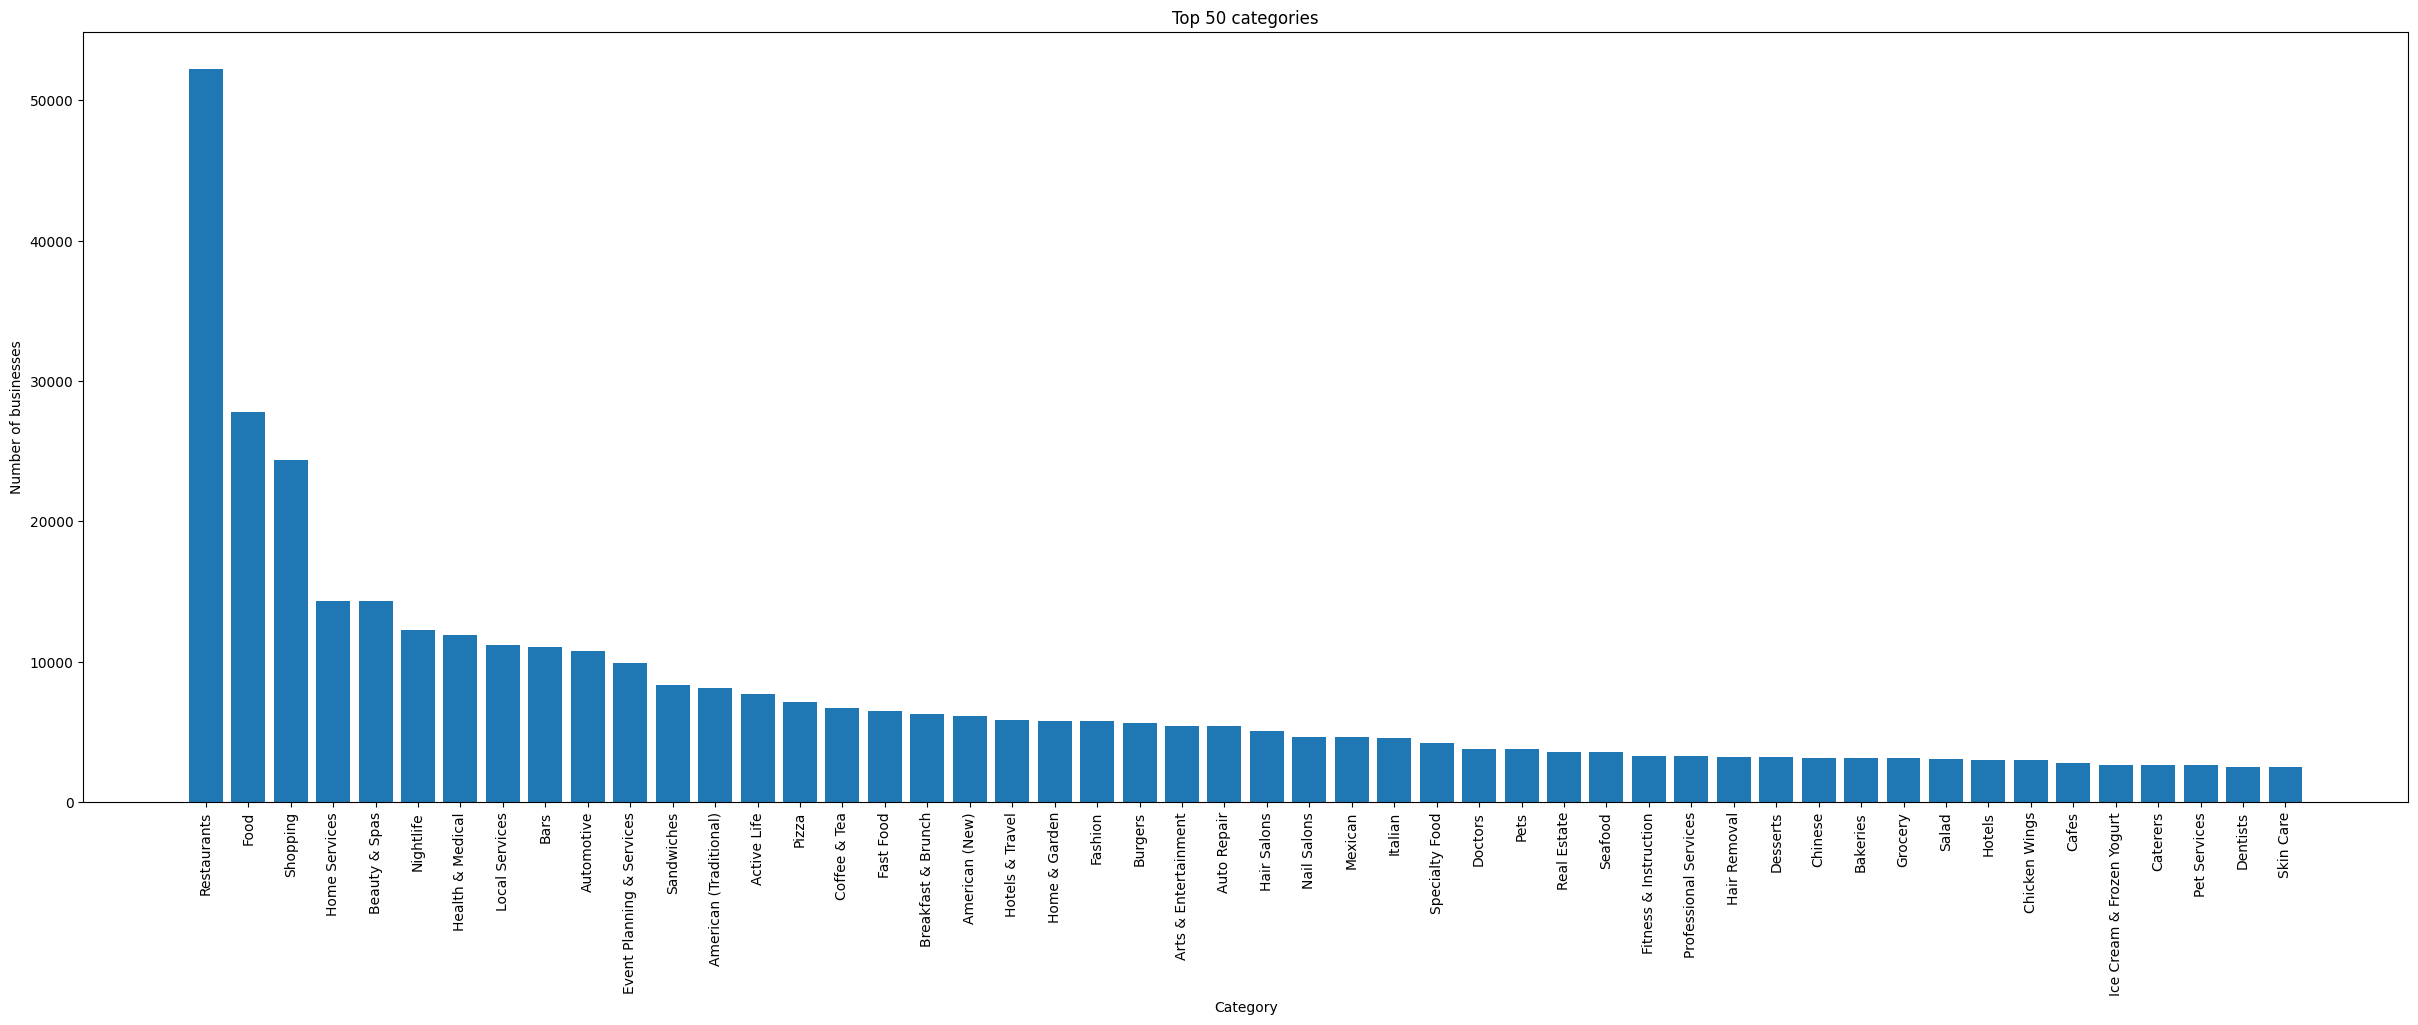

In [10]:
cat_freq = dict(sorted(cat_freq.items(), key=lambda item: item[1], reverse=True))
print("number of categories: ", len(cat_freq))
print("mean number of business in a category: ", np.mean(list(cat_freq.values())))
print("median number of business in a category: ", np.median(list(cat_freq.values())))
print("max number of business in a category: ", np.max(list(cat_freq.values())))
print("max category: ", list(cat_freq.keys())[np.argmax(list(cat_freq.values()))])
print("number of categories with more than 1000 business: ", len([i for i in cat_freq.values() if i > 1000]))
n = 50
print(f"the top {n} categories: ", list(cat_freq.keys())[:n])

cat_freq_top50 = dict(list(cat_freq.items())[:50])
plt.figure(figsize=(30, 10));
plt.bar(cat_freq_top50.keys(), cat_freq_top50.values())
plt.xticks(rotation=90);
plt.title("Top 50 categories")
plt.xlabel("Category")
plt.ylabel("Number of businesses")


Attributes bar plot and information 

Some businesses can have additional information on their page, such as what kind of amenities they provide. Not all business have provided this information, therefore, see below to see the plot of the number of business have each "attribute". 

number of businesses with attributes:  150243
150243
number of attributes:  39
mean number of business with an attribute:  30944.05128205128


Text(0, 0.5, 'Number of businesses')

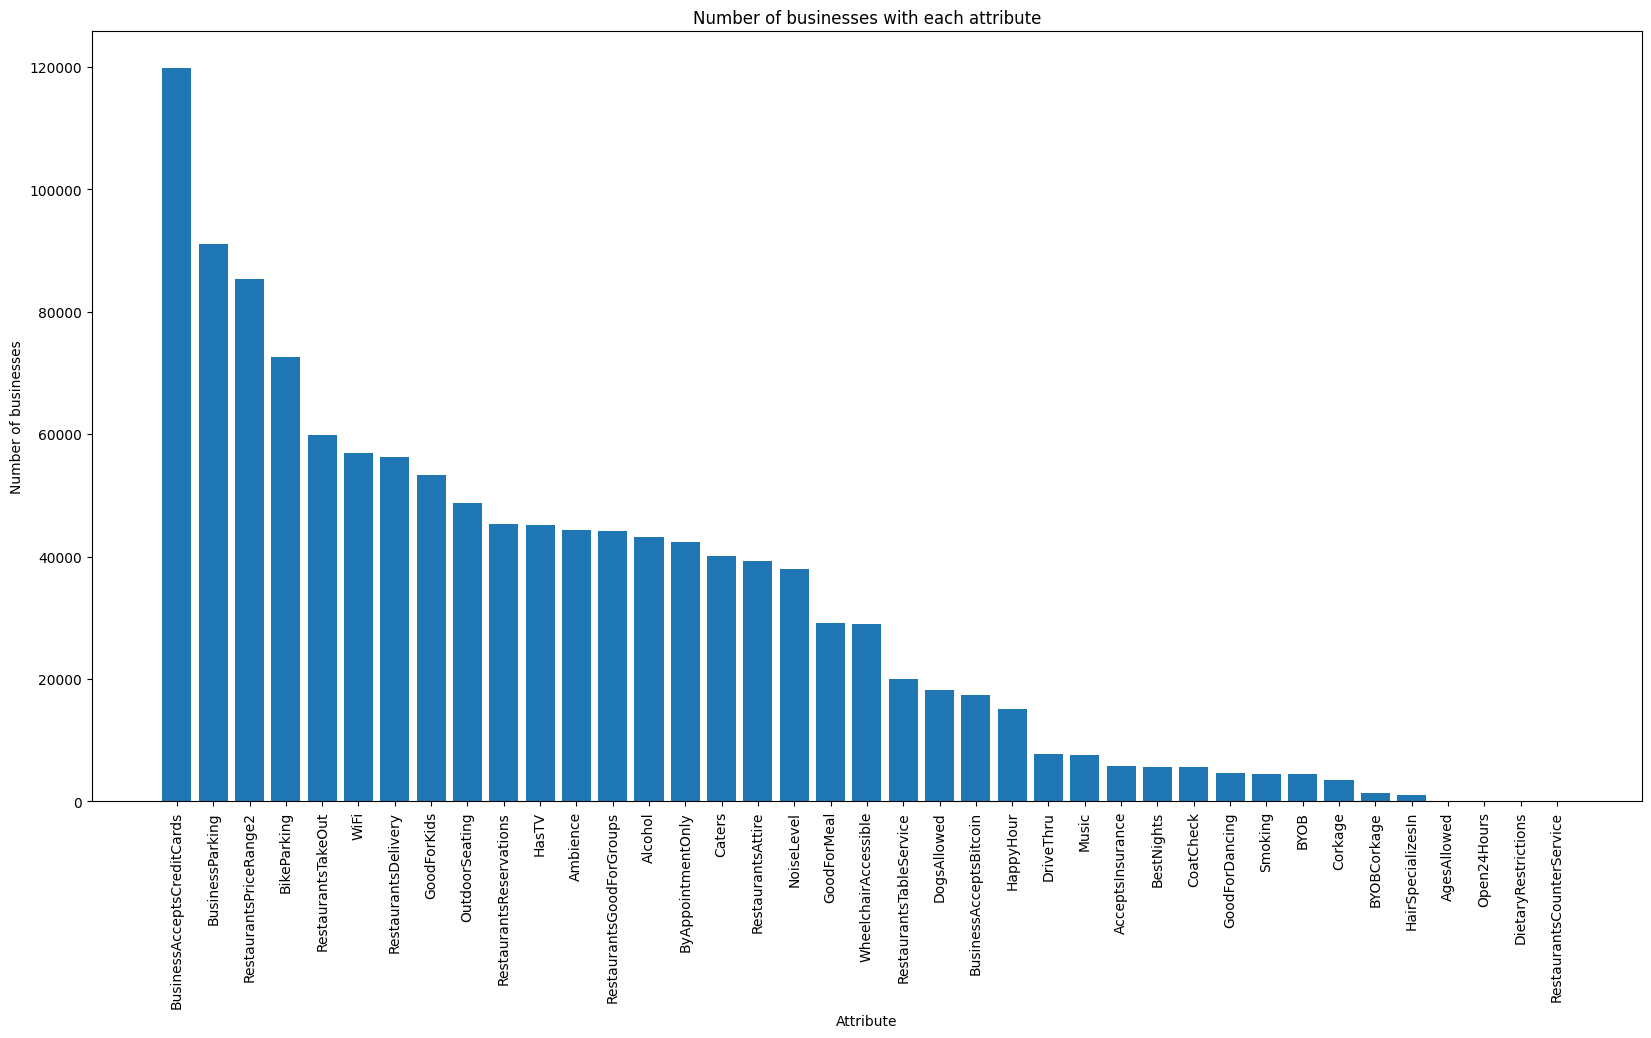

In [11]:
print("number of businesses with attributes: ", len(attribute_df))
print(len(rows))
attribute_freq = dict(sorted(attribute_freq.items(), key=lambda item: item[1], reverse=True))


print("number of attributes: ", len(attribute_freq))
print("mean number of business with an attribute: ", np.mean(list(attribute_freq.values())))


plt.figure(figsize=(20, 10));
plt.bar(attribute_freq.keys(), attribute_freq.values())
plt.xticks(rotation=90);
plt.title("Number of businesses with each attribute")
plt.xlabel("Attribute")
plt.ylabel("Number of businesses")

## Review count plots and information

Below are 2 plots, one that shows the number of reviews received for each month per city. Notice how the number of reviews in Philly is much larger, that is because Philly is a bigger city with more people and restaurants. as of 2023 Philly has a population of 1.55 million and Tampa has a population of 403,000. However, if we average out the number of reviews per restaurant, see second plot, the numbers seem pretty similar. Furthermore, we can see a big drop once restrictions starts in march 2020.  

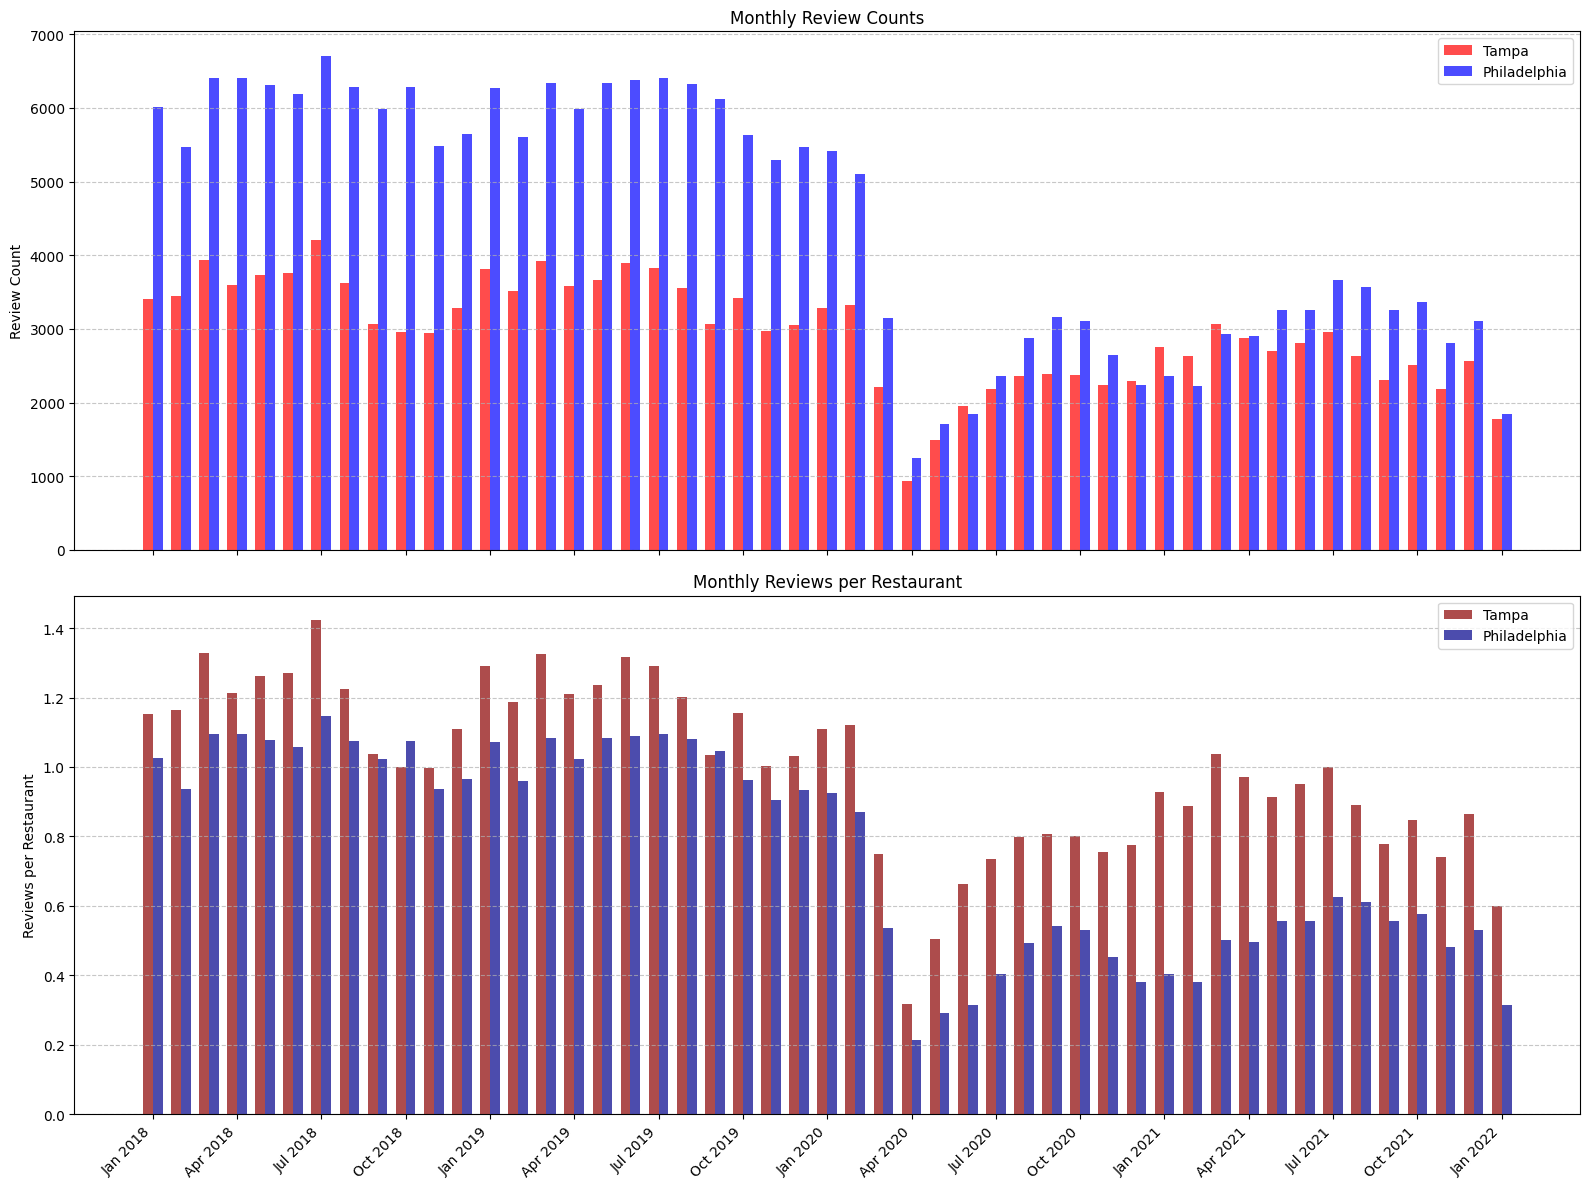

In [12]:
# Filter and prepare data
data_to_plot = reviews[
    (reviews['date'].dt.year >= 2018) & (reviews['date'].dt.year <= 2025)
].copy()

data_to_plot = data_to_plot[data_to_plot['business_id'].isin(restaurant_ids)]

# Add year, month, and datetime
data_to_plot['date'] = data_to_plot['date'].dt.to_period('M').dt.to_timestamp()
monthly_counts = data_to_plot.groupby(['date', 'city']).size().reset_index(name='review_count')

restaurants_in_red = len(restaurants[restaurants['business_id'].isin(red_business_ids)])
restaurants_in_blue = len(restaurants[restaurants['business_id'].isin(blue_business_ids)])

monthly_counts['review_per_rest'] = monthly_counts.apply(
    lambda row: row['review_count'] / restaurants_in_red if row['city'] == red_city
    else row['review_count'] / restaurants_in_blue if row['city'] == blue_city else 0,
    axis=1
)

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
dates = sorted(monthly_counts['date'].unique())
x = np.arange(len(dates))
width = 0.35

def get_series(city, col):
    city_data = monthly_counts[monthly_counts['city'] == city].set_index('date')
    return [city_data[col].get(d, 0) for d in dates]

# Raw counts
ax1.bar(x - width/2, get_series(red_city, 'review_count'), width, label=red_city, color='red', alpha=0.7)
ax1.bar(x + width/2, get_series(blue_city, 'review_count'), width, label=blue_city, color='blue', alpha=0.7)
ax1.set_title('Monthly Review Counts')
ax1.set_ylabel('Review Count')
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Per restaurant
ax2.bar(x - width/2, get_series(red_city, 'review_per_rest'), width, label=red_city, color='darkred', alpha=0.7)
ax2.bar(x + width/2, get_series(blue_city, 'review_per_rest'), width, label=blue_city, color='darkblue', alpha=0.7)
ax2.set_title('Monthly Reviews per Restaurant')
ax2.set_ylabel('Reviews per Restaurant')
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

# X-axis
ax2.set_xticks(x[::3])
ax2.set_xticklabels([d.strftime('%b %Y') for d in dates][::3], rotation=45, ha='right')

plt.tight_layout()
plt.show()


Restaurant vs Shopping business type 

The following plots shows similar information to the previous 2 plots, except we compares all restaurants with all shopping businesses. Here we can see that people review restaurants way more often than they do for "shopping" businesses, even though, "shopping" is third most popular category after "food". 

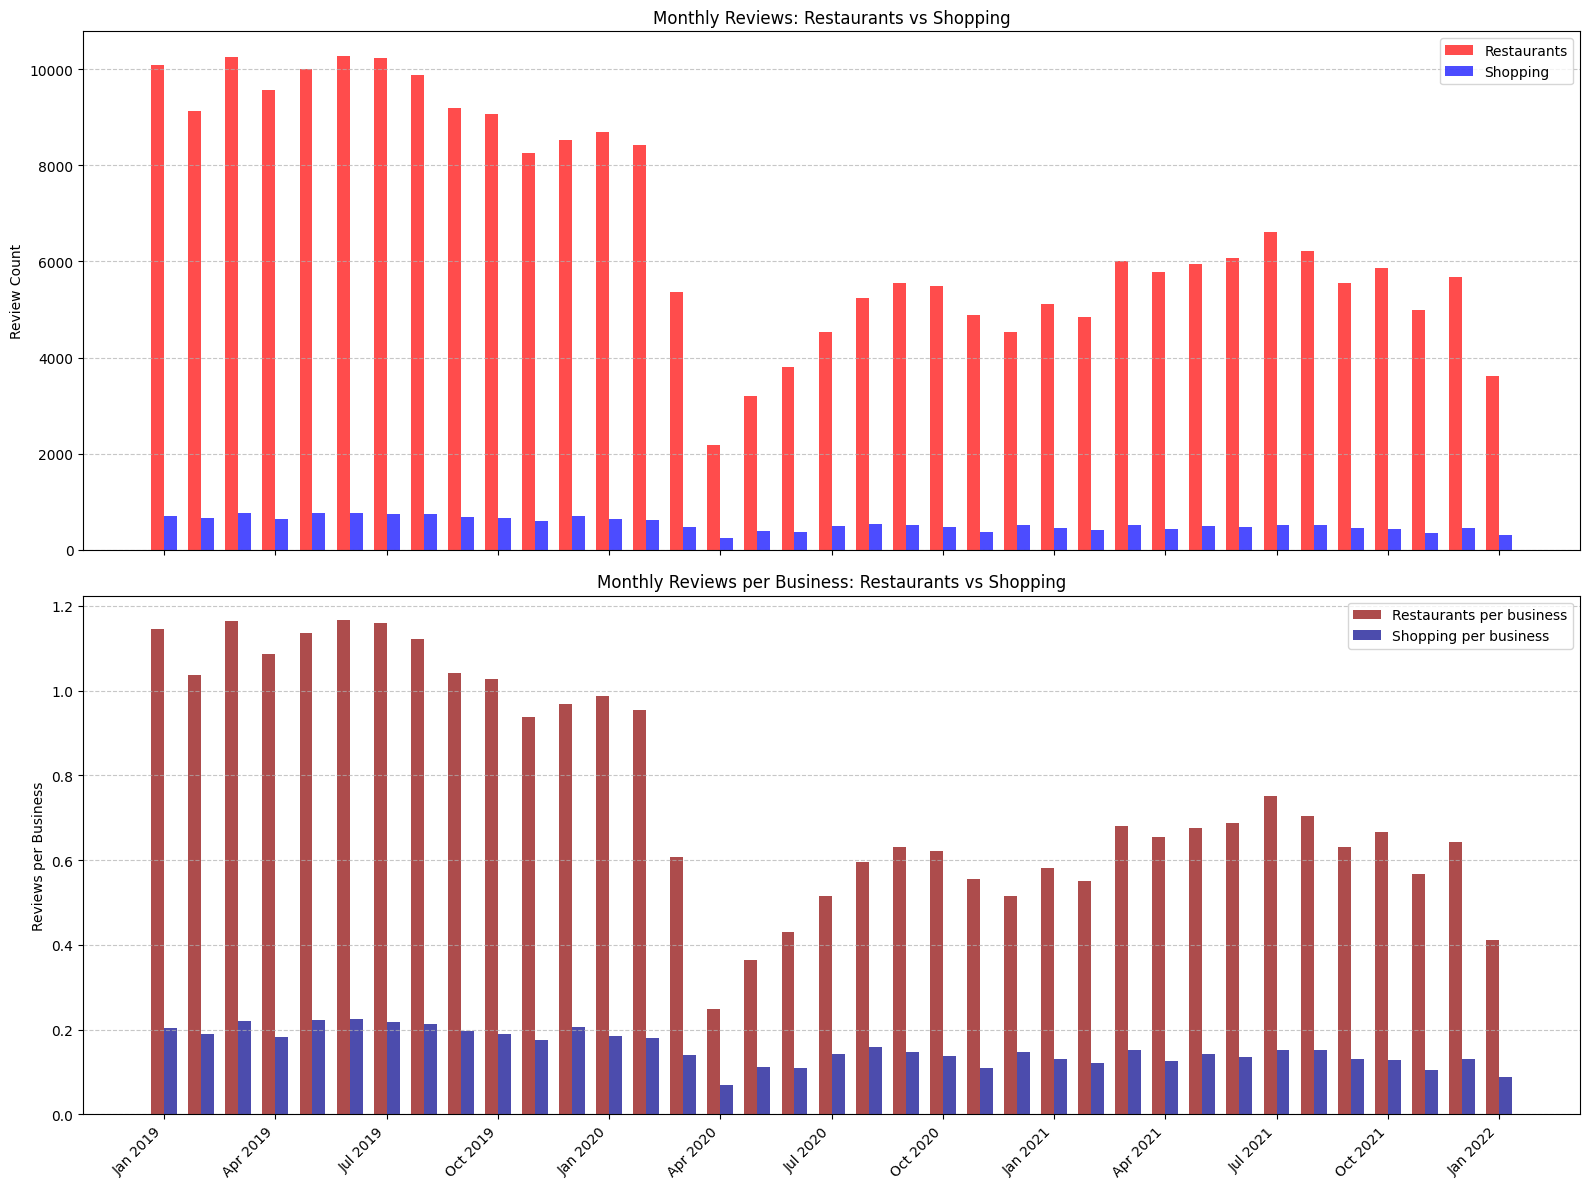

In [13]:
cat1 = "Restaurants"
cat2 = "Shopping"
start, end = "2019-01-01", "2025-01-01"

# Filter reviews and assign category
filtered = reviews[(reviews['date'] >= start) & (reviews['date'] <= end)].copy()
filtered = filtered[filtered['business_id'].isin(restaurant_ids + shopping_ids)]
filtered["category"] = filtered["business_id"].apply(lambda x: cat1 if x in restaurant_ids else cat2)
filtered['date'] = filtered['date'].values.astype('datetime64[M]')  # month precision

# Count reviews
monthly = filtered.groupby(['date', 'category']).size().unstack(fill_value=0).reset_index()
monthly['review_per_rest'] = monthly[cat1] / len(restaurant_ids)
monthly['review_per_shop'] = monthly[cat2] / len(shopping_ids)

# Plot
x = np.arange(len(monthly))
width = 0.35

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), sharex=True)

# Raw review count
ax1.bar(x - width/2, monthly[cat1], width, label=cat1, color='red', alpha=0.7)
ax1.bar(x + width/2, monthly[cat2], width, label=cat2, color='blue', alpha=0.7)
ax1.set_ylabel("Review Count")
ax1.set_title(f"Monthly Reviews: {cat1} vs {cat2}")
ax1.legend()
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Reviews per business
ax2.bar(x - width/2, monthly['review_per_rest'], width, label=f"{cat1} per business", color='darkred', alpha=0.7)
ax2.bar(x + width/2, monthly['review_per_shop'], width, label=f"{cat2} per business", color='darkblue', alpha=0.7)
ax2.set_ylabel("Reviews per Business")
ax2.set_title(f"Monthly Reviews per Business: {cat1} vs {cat2}")
ax2.set_xticks(x[::3])
ax2.set_xticklabels(monthly['date'].dt.strftime('%b %Y')[::3], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Open vs closed 

Open vs closed restaurants information

In [14]:
print("=== Restaurant COVID Activity Summary ===")
print(f"Total restaurants in {red_city} and {blue_city}: {len(restaurants)}")
print(f"Restaurants active during COVID (Mar–Dec 2020): {len(restaurants_in_covid)}")
print(f" - Still open: {len(open_restaurants)} ({len(open_restaurants)/len(restaurants_in_covid)*100:.1f}%)")
print(f" - Closed: {len(closed_restaurants)} ({len(closed_restaurants)/len(restaurants_in_covid)*100:.1f}%)")

print("\n=== Reviews & Check-ins (COVID Period) ===")
print(f"Reviews for open restaurants: {len(open_reviews)}")
print(f"Reviews for closed restaurants: {len(closed_reviews)}")
print(f"Check-ins for open restaurants: {sum(len(d) for d in open_checkins['date_list'])}")
print(f"Check-ins for closed restaurants: {sum(len(d) for d in closed_checkins['date_list'])}")


=== Restaurant COVID Activity Summary ===
Total restaurants in Tampa and Philadelphia: 8812
Restaurants active during COVID (Mar–Dec 2020): 8812
 - Still open: 5489 (62.3%)
 - Closed: 3323 (37.7%)

=== Reviews & Check-ins (COVID Period) ===
Reviews for open restaurants: 41981
Reviews for closed restaurants: 2514
Check-ins for open restaurants: 1376546
Check-ins for closed restaurants: 420276


word cloud (NOT SURE WHAT FUNCTION TO USE)

There are 2 Wordcloud. the first we use TF-IDF, which takes each review as document, counts the frequents terms, and if any frequent terms appears in a lot of documents, then the TF-IDF value become small. The word cloud shows highest TF-IDF terms. This is done for both reviews of open restaurants and closed restaurants. The second wordcloud shows the term frequency only, i.e. if terms are repeated in multiple reviews, then it shows. 

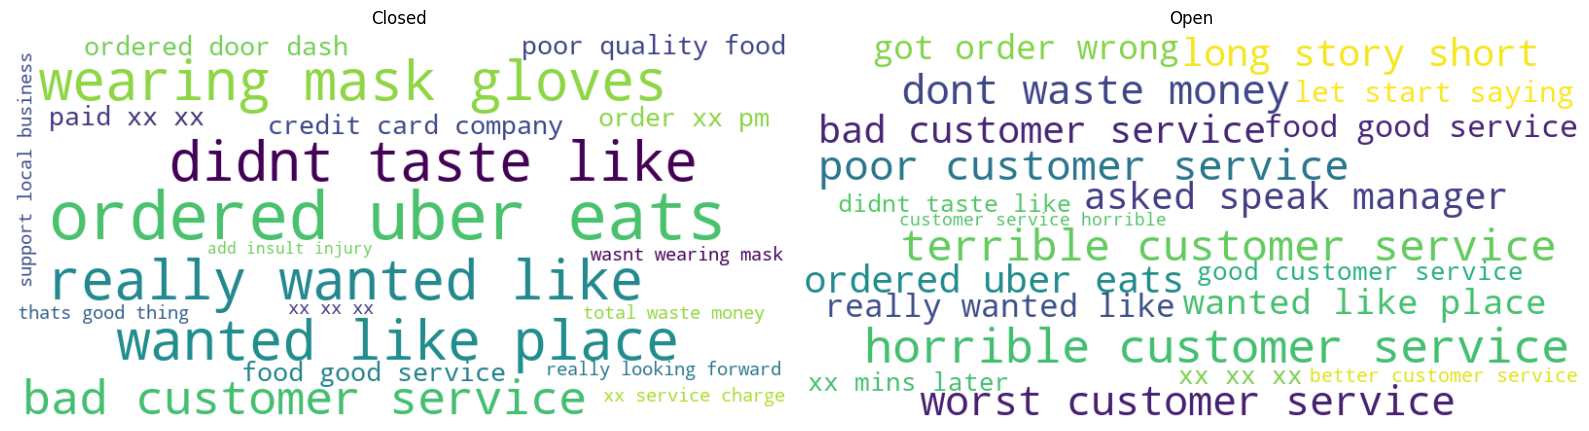

In [15]:
def create_wordcloud(opendf, closeddf, engram, ratings, words=20):
    def preprocess(df):
        texts = df[(df['text'].notna()) & (df["stars"] <= ratings)]['text'].tolist()
        texts = [re.sub(r'\d', 'x', t.replace("'", '').replace("-", '')) for t in texts]
        texts = [re.sub(r'\b(?:time|wait|waited|waiting|waits|min|minutes|chicken)\b', '', text, flags=re.IGNORECASE) for text in texts]
        return texts

    open_text = preprocess(opendf)
    closed_text = preprocess(closeddf)

    vectorizer_open = TfidfVectorizer(stop_words='english', max_features=10000, lowercase=True,
                                      ngram_range=engram)
    tfidf_open = vectorizer_open.fit_transform(open_text)
    tfidf_open_mean = pd.DataFrame(tfidf_open.toarray(), columns=vectorizer_open.get_feature_names_out()).astype(bool).sum()

    vectorizer_closed = TfidfVectorizer(stop_words='english', max_features=10000, lowercase=True,
                                        ngram_range=engram)
    tfidf_closed = vectorizer_closed.fit_transform(closed_text)
    tfidf_closed_mean = pd.DataFrame(tfidf_closed.toarray(), columns=vectorizer_closed.get_feature_names_out()).astype(bool).sum()

    wordcloud_open = WordCloud(width=800, height=400, max_words=words, background_color='white')\
                     .generate_from_frequencies(tfidf_open_mean)
    wordcloud_closed = WordCloud(width=800, height=400, max_words=words, background_color='white')\
                       .generate_from_frequencies(tfidf_closed_mean)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(wordcloud_closed, interpolation='bilinear')
    ax[0].set_title("Closed")
    ax[0].axis("off")

    ax[1].imshow(wordcloud_open, interpolation='bilinear')
    ax[1].set_title("Open")
    ax[1].axis("off")

    plt.tight_layout()
create_wordcloud(open_reviews, closed_reviews, engram=(3,3), ratings=2, words=20)


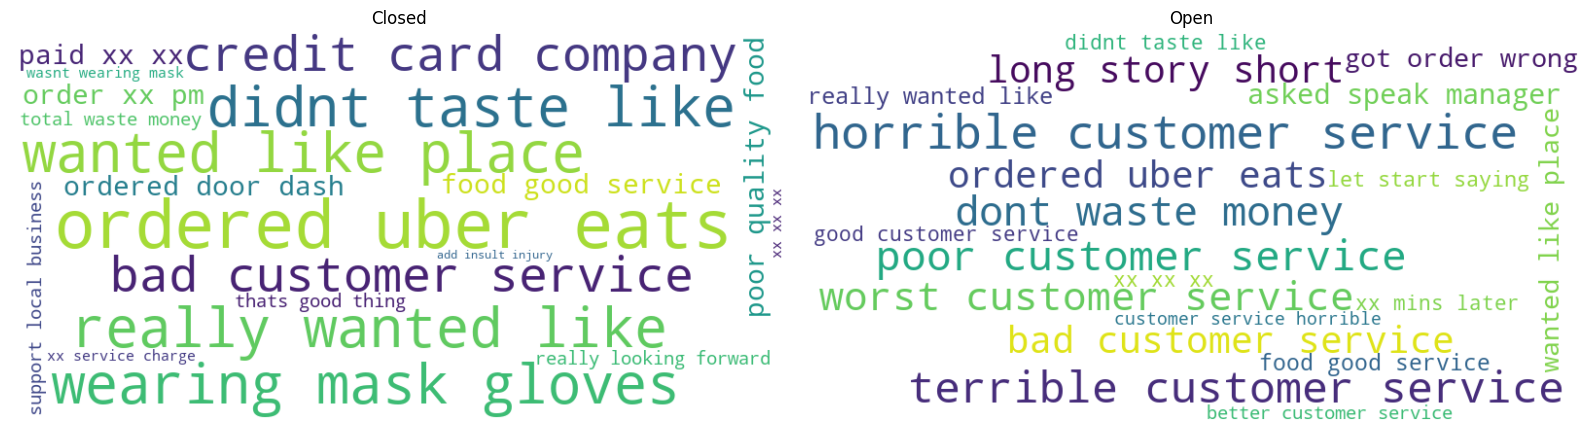

In [16]:
def create_wordcloud_count(opendf, closeddf, engram, ratings, words=20):
    def preprocess(df):
        texts = df[(df['text'].notna()) & (df["stars"] <= ratings)]['text'].tolist()
        texts = [re.sub(r'\d', 'x', t.replace("'", '').replace("-", '')) for t in texts]
        texts = [re.sub(r'\b(?:time|wait|waited|waiting|waits|min|minutes|chicken)\b', '', text, flags=re.IGNORECASE) for text in texts]
        return texts

    open_text = preprocess(opendf)
    closed_text = preprocess(closeddf)

    vectorizer_open = CountVectorizer(stop_words='english', max_features=10000, lowercase=True,
                                      ngram_range=engram)
    count_open = vectorizer_open.fit_transform(open_text)
    count_open_sum = pd.DataFrame(count_open.toarray(), columns=vectorizer_open.get_feature_names_out()).astype(bool).sum()

    vectorizer_closed = CountVectorizer(stop_words='english', max_features=10000, lowercase=True,
                                        ngram_range=engram)
    count_closed = vectorizer_closed.fit_transform(closed_text)
    count_closed_sum = pd.DataFrame(count_closed.toarray(), columns=vectorizer_closed.get_feature_names_out()).astype(bool).sum()

    wordcloud_open = WordCloud(width=800, height=400, max_words=words, background_color='white')\
                     .generate_from_frequencies(count_open_sum)
    wordcloud_closed = WordCloud(width=800, height=400, max_words=words, background_color='white')\
                       .generate_from_frequencies(count_closed_sum)

    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].imshow(wordcloud_closed, interpolation='bilinear')
    ax[0].set_title("Closed")
    ax[0].axis("off")

    ax[1].imshow(wordcloud_open, interpolation='bilinear')
    ax[1].set_title("Open")
    ax[1].axis("off")

    plt.tight_layout()
create_wordcloud_count(open_reviews, closed_reviews, engram=(3,3), ratings=2, words=20)
# def create_wordcloud(opendf, closeddf, engram, ratings, words=20,  level='group'):
#     def preprocess_group(df):
#         texts = df[(df['text'].notna()) & (df["stars"] <= ratings)]['text']
#         text = ' '.join(texts)
#         text = re.sub(r'\d', 'x', text.replace("'", '').replace("-", ''))
#         ## remove time complaints
#         text = re.sub(r'\b(?:time|wait|waited|waiting|waits|min|minutes|chicken)\b', '', text, flags=re.IGNORECASE)
#         return [text]

#     def preprocess_review(df):
#         texts = df[(df['text'].notna()) & (df["stars"] <= ratings)]['text'].tolist()
#         texts = [re.sub(r'\d', 'x', t.replace("'", '').replace("-", '')) for t in texts]
#         return texts

#     if level == 'group':
#         open_text = preprocess_group(opendf)
#         closed_text = preprocess_group(closeddf)
#     elif level == 'review':
#         open_text = preprocess_review(opendf)
#         closed_text = preprocess_review(closeddf)
#     else:
#         raise ValueError("Invalid level")

#     vectorizer_open = TfidfVectorizer(stop_words='english', max_features=10000, lowercase=True,
#                                       ngram_range=engram)
#     tfidf_open = vectorizer_open.fit_transform(open_text)
#     tfidf_open_mean = pd.DataFrame(tfidf_open.toarray(), columns=vectorizer_open.get_feature_names_out()).mean()

#     vectorizer_closed = TfidfVectorizer(stop_words='english', max_features=10000, lowercase=True,
#                                         ngram_range=engram)
#     tfidf_closed = vectorizer_closed.fit_transform(closed_text)
#     tfidf_closed_mean = pd.DataFrame(tfidf_closed.toarray(), columns=vectorizer_closed.get_feature_names_out()).mean()

#     wordcloud_open = WordCloud(width=800, height=400, max_words=words, background_color='white')\
#                      .generate_from_frequencies(tfidf_open_mean)
#     wordcloud_closed = WordCloud(width=800, height=400, max_words=words, background_color='white')\
#                        .generate_from_frequencies(tfidf_closed_mean)

#     fig, ax = plt.subplots(1, 2, figsize=(16, 8))
#     ax[0].imshow(wordcloud_closed, interpolation='bilinear')
#     ax[0].set_title("Closed")
#     ax[0].axis("off")

#     ax[1].imshow(wordcloud_open, interpolation='bilinear')
#     ax[1].set_title("Open")
#     ax[1].axis("off")



#     plt.tight_layout()
# create_wordcloud(open_reviews, closed_reviews, engram=(3,3), ratings=3, words=20)


Attribute Statistics between open and closed restaurants 

Here we print for each attribute we calculate the, p-value, % open has it, % closed has it, mean open, mean closed, count open and count closed. This is done to see if there is any attributes that are significantly different between open and closed restaurants.   

In [17]:
results = []
for col in attribute_df.columns:
    try:
        if attribute_df[col].nunique() > 3:
            continue
    except TypeError:
        continue

    open_vals = open_attributes[col]
    closed_vals = closed_attributes[col]

    values = pd.concat([open_vals, closed_vals])
    groups = ['open'] * len(open_vals) + ['closed'] * len(closed_vals)

    table = pd.crosstab(values, groups)
    if table.shape[0] < 2 or table.shape[1] < 2:
        continue

    chi2, p, _, _ = chi2_contingency(table)
    results.append((col, p))

results = sorted(results, key=lambda x: x[1])

less_05 = [(col, p) for col, p in results if p < 0.05]
less_01 = [(col, p) for col, p in results if p < 0.01]

print("Attributes with p < 0.05:", less_05)
print("Attributes with p < 0.01:", less_01)
print("All results:", results)

print(f"\n{'Attribute':<30}{'p-value':<10}{'% open has it':<15}{'% closed has it':<17}{'mean open':<12}{'mean closed':<12}{'count open':<12}{'count closed'}")
for col, p in results:
    open_total = len(open_attributes)
    closed_total = len(closed_attributes)

    open_clean = open_attributes[col]
    closed_clean = closed_attributes[col]

    open_pct = round(open_clean.notna().sum() / open_total * 100, 2)
    closed_pct = round(closed_clean.notna().sum() / closed_total * 100, 2)

    open_count = open_clean.count()
    closed_count = closed_clean.count()

    try:
        open_mean = round(pd.to_numeric(open_clean, errors='coerce').mean(), 2)
        closed_mean = round(pd.to_numeric(closed_clean, errors='coerce').mean(), 2)
    except:
        open_mean = closed_mean = 'n/a'

    print(f"{col:<30}{round(p, 4):<10}{str(open_pct) + '%':<15}{str(closed_pct) + '%':<17}{str(open_mean):<12}{str(closed_mean):<12}{open_count:<12}{closed_count}")




Attributes with p < 0.05: [('RestaurantsDelivery', np.float64(1.4936602640100124e-159)), ('HasTV', np.float64(1.7596226684011137e-56)), ('HappyHour', np.float64(3.0961771528671522e-27)), ('RestaurantsReservations', np.float64(1.1566050929018542e-18)), ('DriveThru', np.float64(1.2622387170307099e-12)), ('GoodForKids', np.float64(4.0775790140353195e-07)), ('RestaurantsGoodForGroups', np.float64(2.0089502675677648e-06)), ('RestaurantsTakeOut', np.float64(1.1797005466949119e-05)), ('Alcohol', np.float64(1.973691505306067e-05)), ('BikeParking', np.float64(0.00024321481376200606)), ('WiFi', np.float64(0.011429980529753227)), ('Corkage', np.float64(0.04309499281990467))]
Attributes with p < 0.01: [('RestaurantsDelivery', np.float64(1.4936602640100124e-159)), ('HasTV', np.float64(1.7596226684011137e-56)), ('HappyHour', np.float64(3.0961771528671522e-27)), ('RestaurantsReservations', np.float64(1.1566050929018542e-18)), ('DriveThru', np.float64(1.2622387170307099e-12)), ('GoodForKids', np.float

Word frequency 

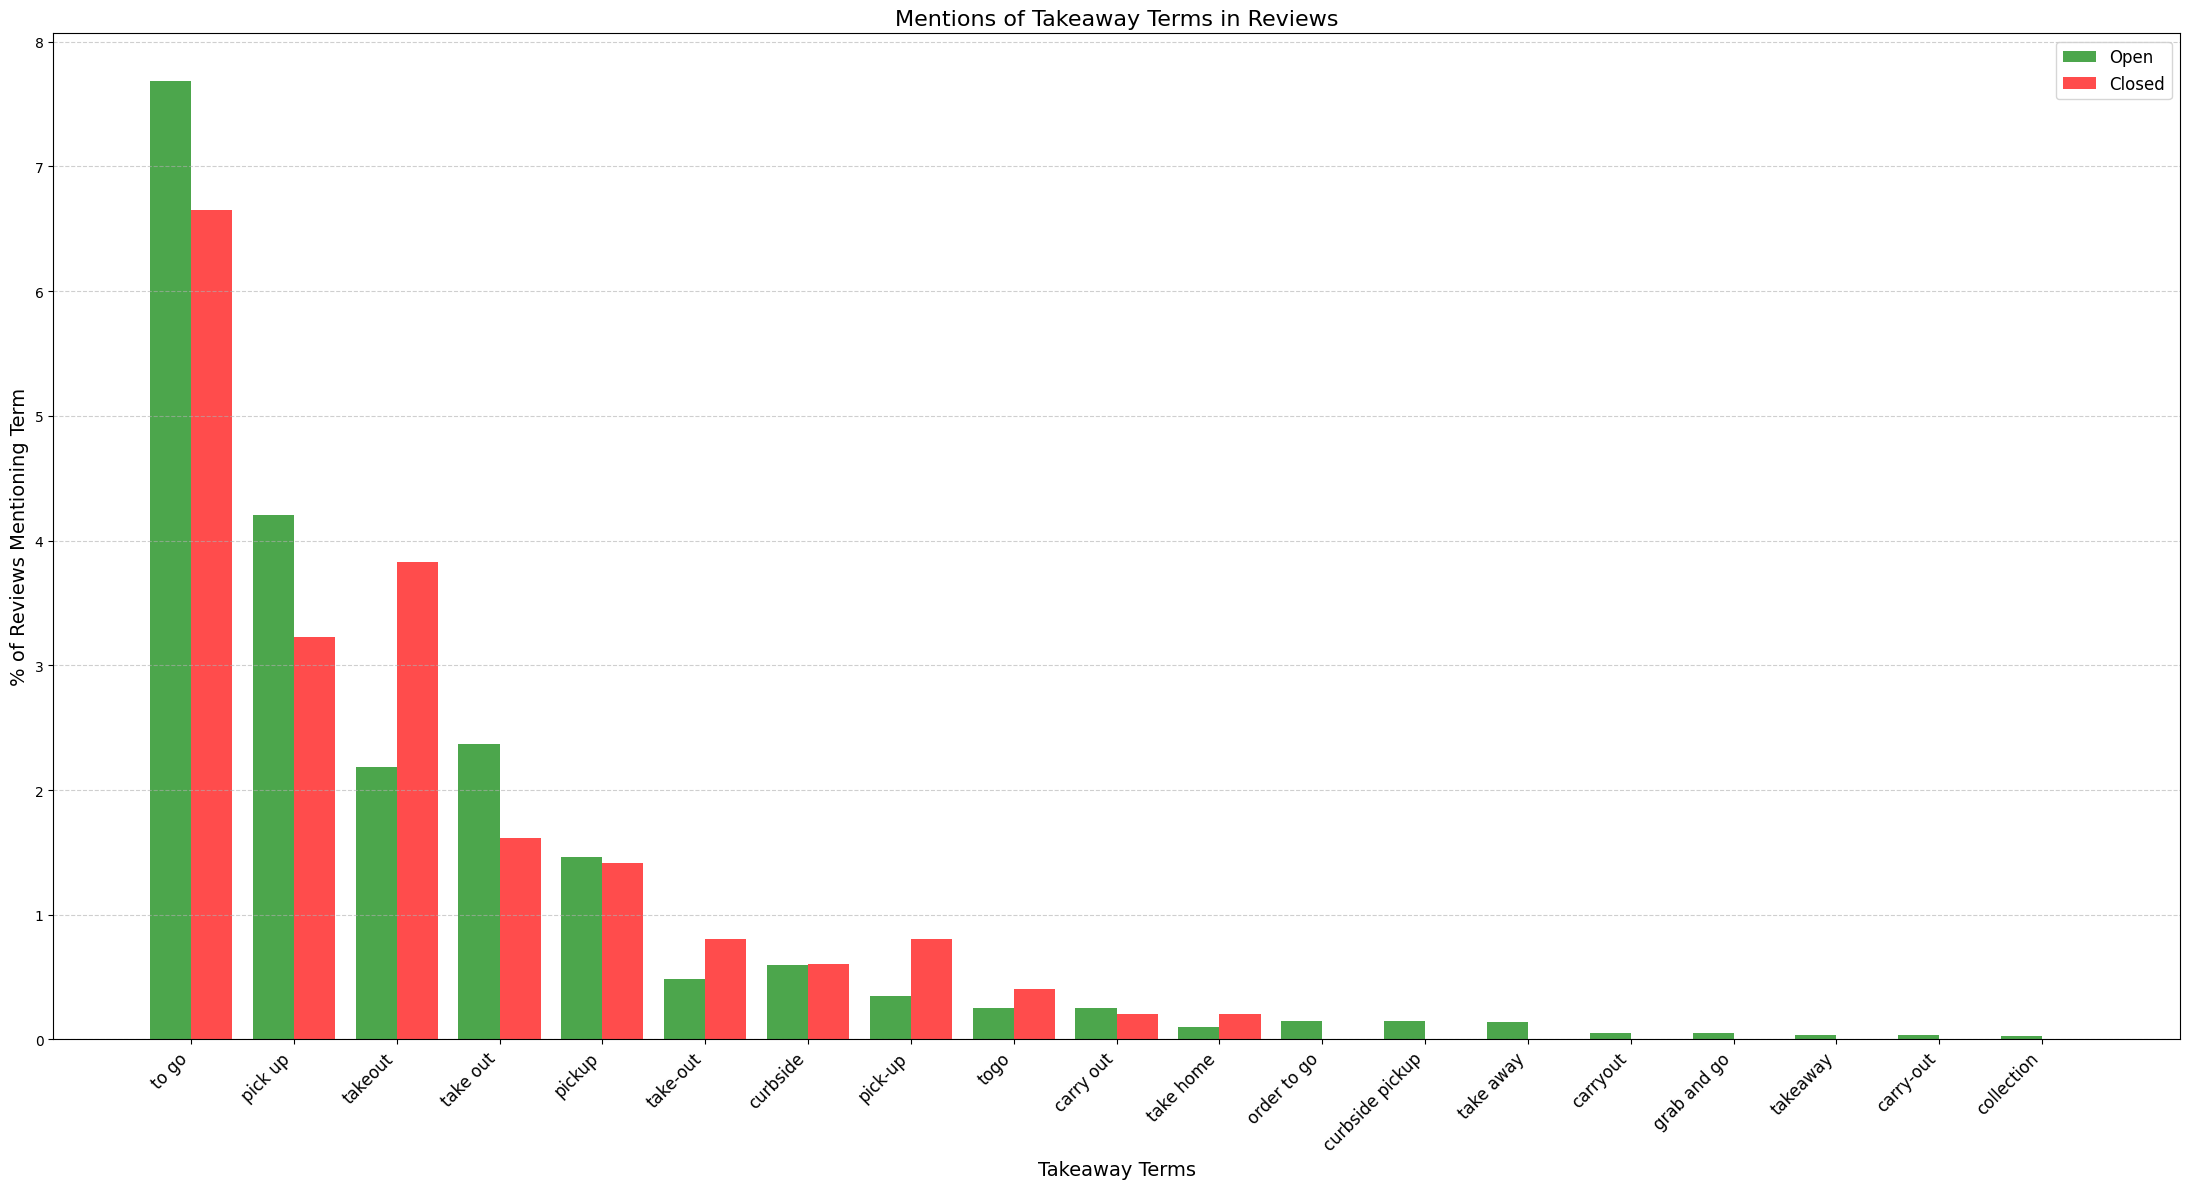

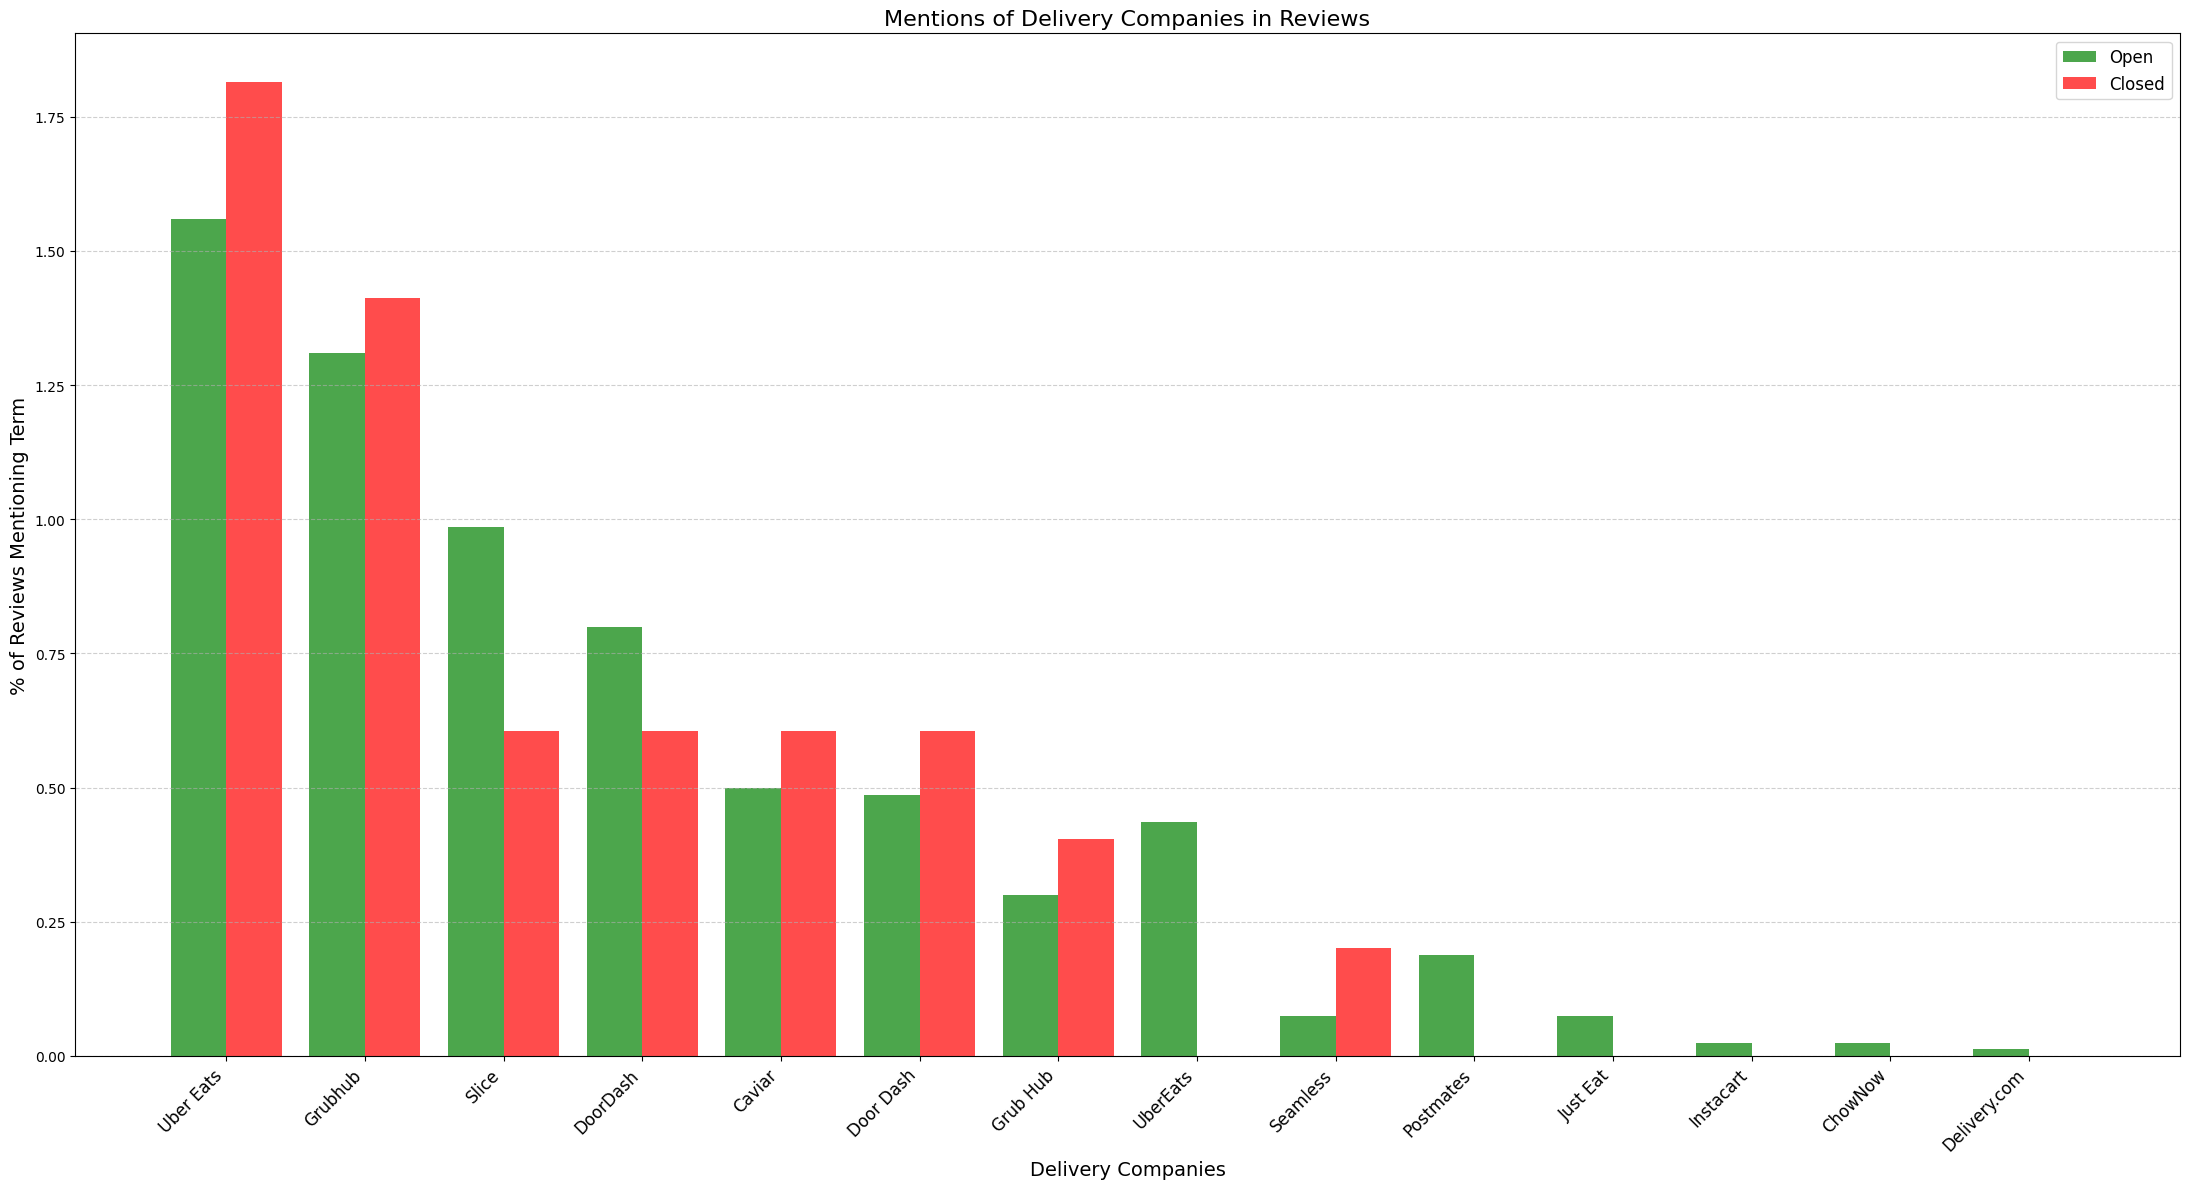

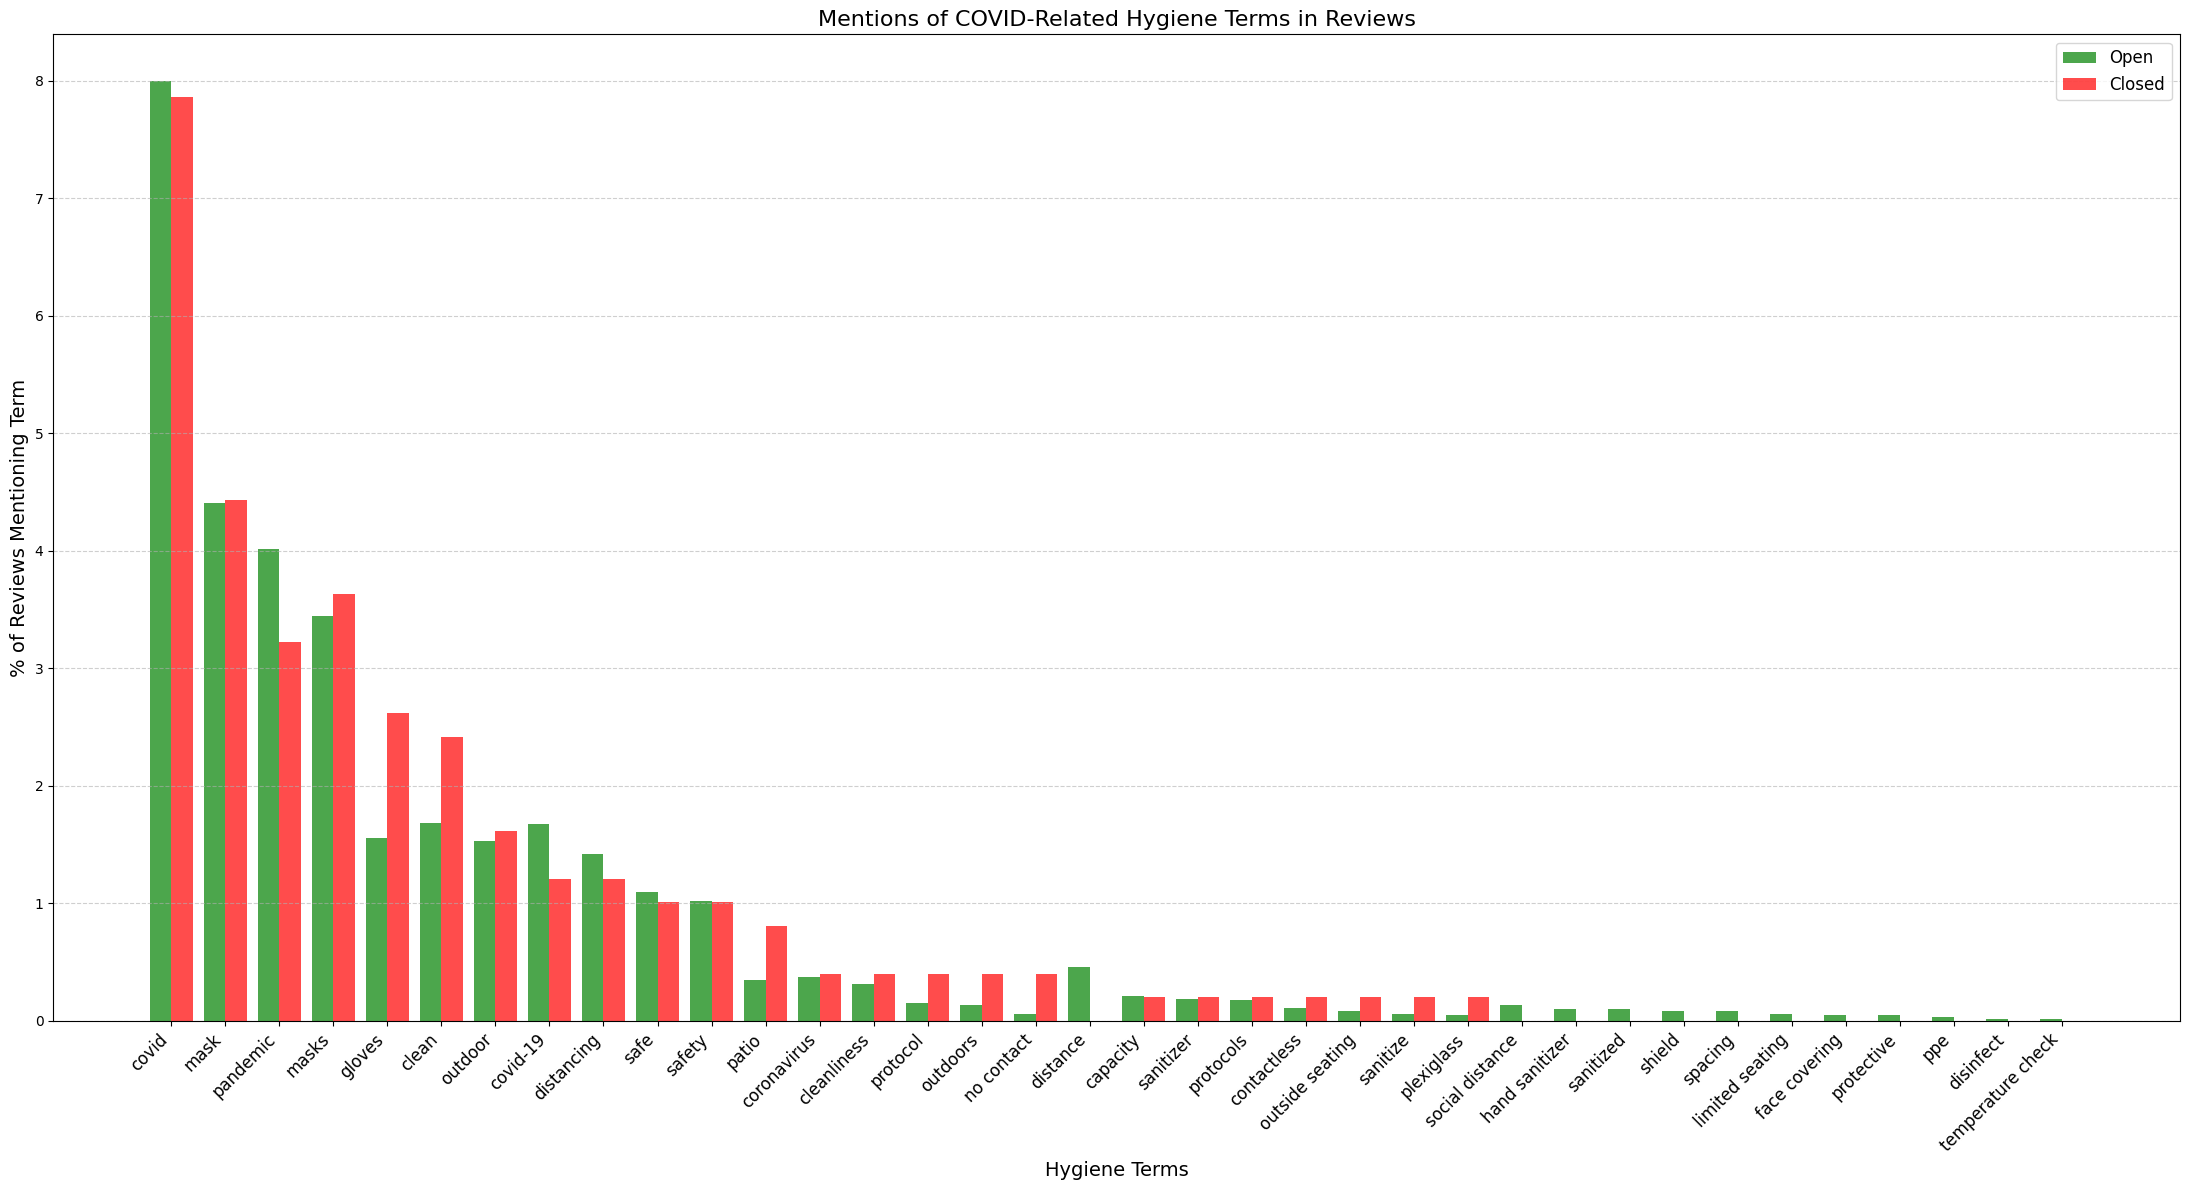

In [18]:
takeaway_terms = [
    "takeaway", "take-away", "take away", "take-out", "take out", "takeout",
    "to go", "togo", "pickup", "pick-up", "pick up", "take-home", "take home",
    "carryout", "carry-out", "carry out", "collected food", "collection",
    "order to go", "grab and go", "curbside", "curbside pickup"
]

delivery_companies = [
    "UberEats", "Uber Eats", "DoorDash", "Door Dash", "Grubhub", "Grub Hub",
    "Postmates", "Seamless", "Deliveroo", "Just Eat", "Instacart", "Caviar",
    "Delivery.com", "Foodler", "ChowNow", "Slice", "goPuff", "Bite Squad",
    "Eat Street", "EatStreet", "Waitr", "Zomato"
]

hygiene_terms = [
    "mask", "masks", "face covering", "sanitizer", "hand sanitizer", "sanitize", "sanitized",
    "clean", "cleanliness", "disinfect", "disinfected", "distance", "distancing", "social distance",
    "covid", "covid-19", "coronavirus", "pandemic", "safety", "safe", "protocol", "protocols",
    "outdoor", "outdoors", "patio", "outside seating", "contactless", "contact-free", "no contact",
    "gloves", "ppe", "protective", "plexiglass", "shield", "temperature check", "health check", 
    "fever", "capacity", "limited seating", "spacing"
]

def term_mention_percentages(texts, term_list):
    term_set = {term: 0 for term in term_list}
    total = len(texts)
    for text in texts:
        if not isinstance(text, str): continue
        text_l = text.lower()
        for term in term_list:
            if re.search(rf'\b{re.escape(term.lower())}\b', text_l):
                term_set[term] += 1
    return {k: v * 100 / total for k, v in term_set.items()}

def plot_comparison(open_freq, closed_freq, terms, title, xlabel):
    terms = [t for t in terms if open_freq[t] > 0 or closed_freq[t] > 0]
    terms = sorted(terms, key=lambda t: open_freq[t] + closed_freq[t], reverse=True)
    x = np.arange(len(terms))
    width = 0.4
    open_vals = [open_freq[t] for t in terms]
    closed_vals = [closed_freq[t] for t in terms]

    plt.figure(figsize=(22, 12))
    plt.bar(x - width/2, open_vals, width, label='Open', color='green', alpha=0.7)
    plt.bar(x + width/2, closed_vals, width, label='Closed', color='red', alpha=0.7)
    plt.xticks(x, terms, rotation=45, ha='right', fontsize=12)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('% of Reviews Mentioning Term', fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Texts
open_texts = open_reviews[open_reviews["stars"]<3]['text'].tolist()
closed_texts = closed_reviews[closed_reviews["stars"]<3]['text'].tolist()

# Frequencies
open_takeaway = term_mention_percentages(open_texts, takeaway_terms)
closed_takeaway = term_mention_percentages(closed_texts, takeaway_terms)
open_delivery = term_mention_percentages(open_texts, delivery_companies)
closed_delivery = term_mention_percentages(closed_texts, delivery_companies)
open_hygiene = term_mention_percentages(open_texts, hygiene_terms)
closed_hygiene = term_mention_percentages(closed_texts, hygiene_terms)

# Plots
plot_comparison(open_takeaway, closed_takeaway, takeaway_terms,
                'Mentions of Takeaway Terms in Reviews', 'Takeaway Terms')

plot_comparison(open_delivery, closed_delivery, delivery_companies,
                'Mentions of Delivery Companies in Reviews', 'Delivery Companies')

plot_comparison(open_hygiene, closed_hygiene, hygiene_terms,
                'Mentions of COVID-Related Hygiene Terms in Reviews', 'Hygiene Terms')


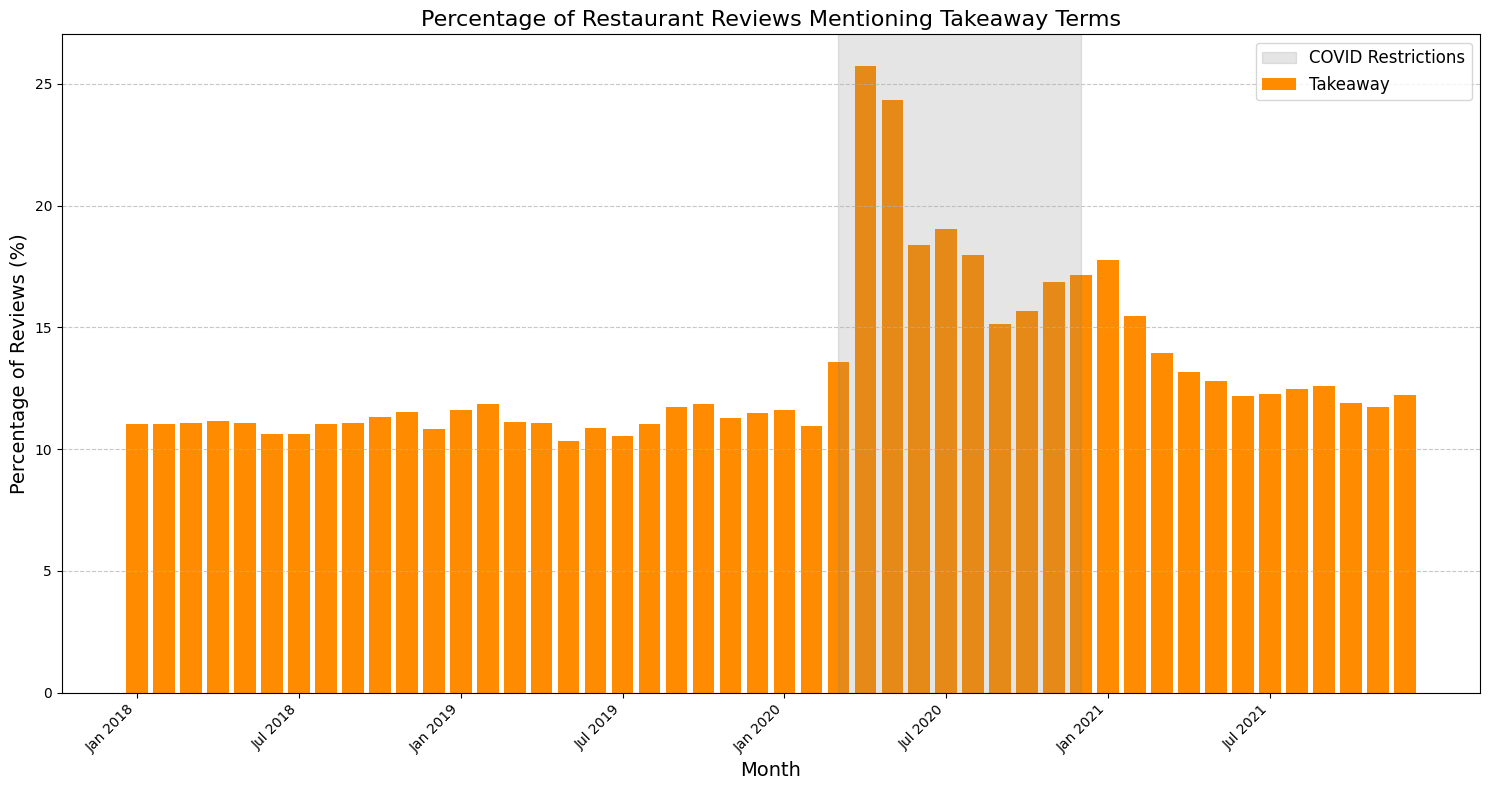

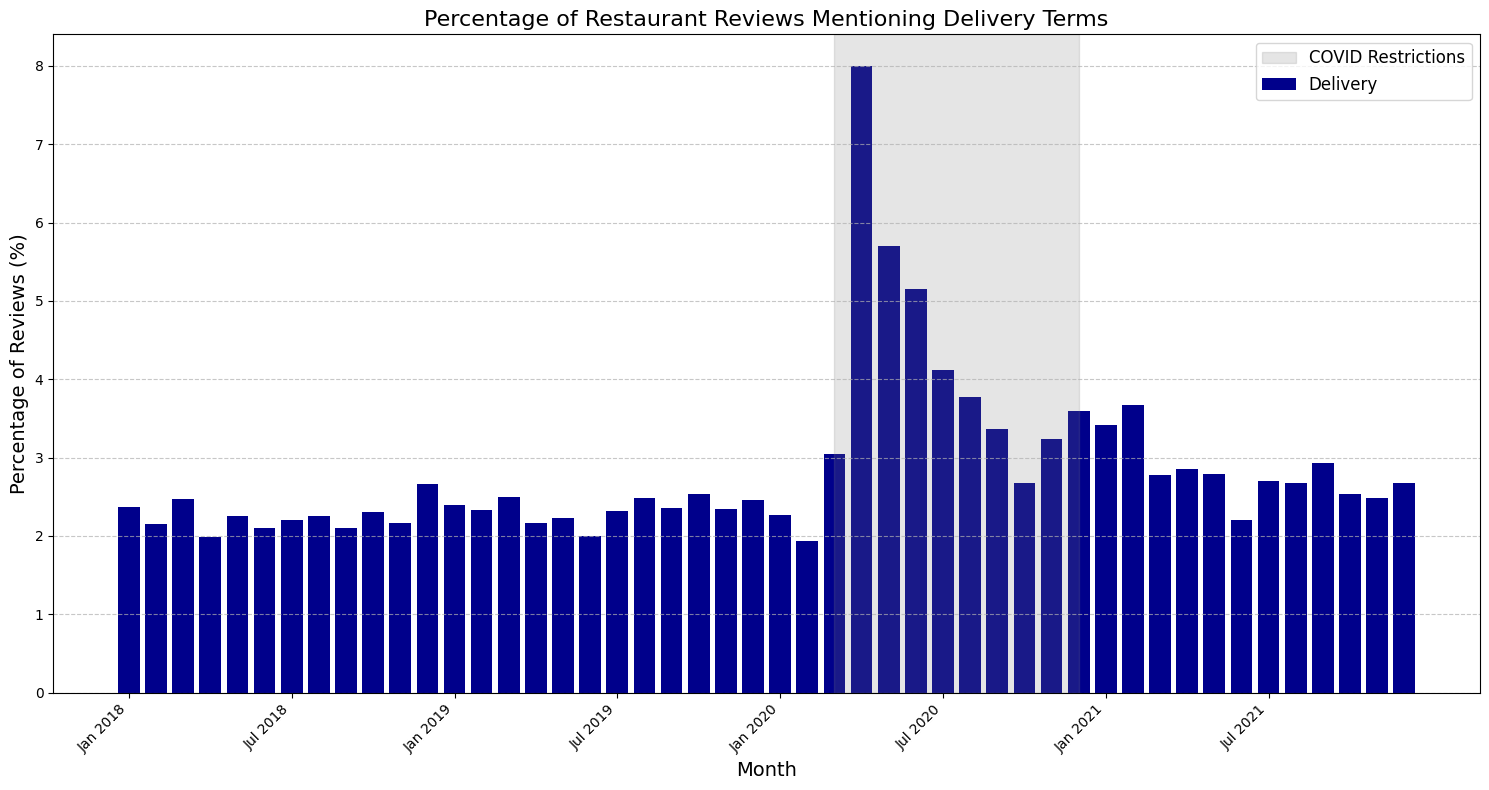

In [33]:
def plot_term_trends_proportion(term_list_name, terms, start_year=2018, end_year=2021):
    # Pre-filter to only restaurant reviews in the relevant timeframe
    filtered_reviews = restaurants_reviews[
        (restaurants_reviews['date'] >= f'{start_year}-01-01')
    ].copy()
    
    # Create month column for grouping
    filtered_reviews['month'] = filtered_reviews['date'].dt.to_period('M').dt.to_timestamp()
    
    # Combine terms into regex pattern for efficient searching
    pattern = '|'.join(r'\b' + re.escape(term.lower()) + r'\b' for term in terms)
    
    # Create flag for each review
    filtered_reviews[f'has_{term_list_name}'] = filtered_reviews['text'].str.lower().str.contains(
        pattern, regex=True, na=False)
    
    # Group by month and calculate both counts and totals
    monthly_mentioning = filtered_reviews[filtered_reviews[f'has_{term_list_name}']].groupby('month').size()
    monthly_total = filtered_reviews.groupby('month').size()
    
    # Create dataframe with all months and calculate proportions
    date_range = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-01', freq='MS')
    monthly_data = pd.DataFrame(index=date_range)
    monthly_data['mentioning'] = monthly_mentioning
    monthly_data['total'] = monthly_total
    monthly_data = monthly_data.fillna(0)
    
    # Calculate proportion (percentage)
    monthly_data['proportion'] = (monthly_data['mentioning'] / monthly_data['total']) * 100
    monthly_data['proportion'] = monthly_data['proportion'].fillna(0)
    
    # Plot
    plt.figure(figsize=(15, 8))
    x = np.arange(len(monthly_data.index))
    
    # Create bars
    plt.bar(x, monthly_data['proportion'], 
           label=term_list_name, color='darkorange' if term_list_name == 'Takeaway' else 'darkblue')
    
    # Add COVID period shading
    covid_start_idx = np.where(monthly_data.index == pd.to_datetime('2020-03-01'))[0][0]
    covid_end_idx = np.where(monthly_data.index == pd.to_datetime('2020-12-01'))[0][0]
    plt.axvspan(covid_start_idx, covid_end_idx, color='gray', alpha=0.2, label='COVID Restrictions')
    
    # Set x-ticks and labels - show fewer labels for readability with extended range
    step = 6  # Show every 6 months to avoid overcrowding
    plt.xticks(x[::step], [d.strftime('%b %Y') for d in monthly_data.index[::step]], rotation=45, ha='right')
    
    # Add labels and styling
    plt.title(f'Percentage of Restaurant Reviews Mentioning {term_list_name} Terms', fontsize=16)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Percentage of Reviews (%)', fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    return plt.show()

# Plot separate graphs for each term list with extended range
plot_term_trends_proportion('Takeaway', takeaway_terms)
plot_term_trends_proportion('Delivery', delivery_companies)